# **Analisis Prediksi NO2 Menggunakan KNN Regression**

### **1. Pengambilan Data (Scraping)**

Data diambil dari sumber Dataspace Coneous yang menyediakan informasi cuaca dan kualitas udara. Scraping dilakukan untuk daerah **Surakarta** dan mengambil **periode 1 tahun penuh**, dengan mengambil variabel utama yaitu konsentrasi NO2 per hari.

Data mentah memiliki beberapa kolom, namun untuk keperluan analisis, hanya kolom NO2 dan tanggal (date) yang digunakan.

Authenticated using refresh token.
0:00:00 Job 'j-25102307552043458de4cbce5b2f0d05': send 'start'
0:00:13 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:19 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:25 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:34 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:44 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:56 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:12 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:31 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:56 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:02:26 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:03:03 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:03:50 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:04:49 Job 'j-2510230755204345

/tmp/ipython-input-3794286045.py:67: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


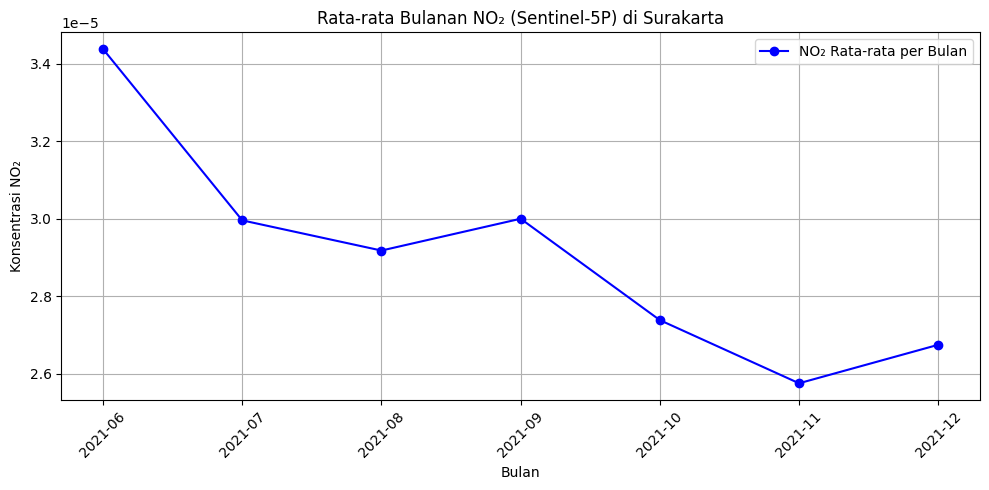

In [ ]:
!pip install openeo
import openeo
import pandas as pd
import matplotlib.pyplot as plt

# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. AOI: poligon kedua dari data kamu
aoi = {
    "type": "Polygon",
    "coordinates": [
          [
            [110.73384843270605, -7.506125504050544],
            [110.73384843270605, -7.629910709610229],
            [110.93095130302544, -7.629910709610229],
            [110.93095130302544, -7.506125504050544],
            [110.73384843270605, -7.506125504050544]
          ]
        ],
}

# 3. Ambil data Sentinel-5P (band "NO2")
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent = {
    "west": 110.73384843270605,
    "south": -7.629910709610229,
    "east": 110.93095130302544,
    "north": -7.506125504050544
},
    temporal_extent=["2021-06-01", "2021-12-30"],
    bands=["NO2"],
)

# 4. Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (rata-rata dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV")

# 8. Unduh hasil job
results = job.get_results()
results.download_files("Surakarta")

# 9. Baca file CSV hasil
import os
for f in os.listdir("Surakarta"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("Surakarta", f))
        print("File ditemukan:", f)
        break

# 10. Pastikan kolom tanggal benar
df["date"] = pd.to_datetime(df["date"])

# 11. Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12. Hitung rata-rata NO2 per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# 13. Visualisasi hasil
plt.figure(figsize=(10,5))
plt.plot(df_monthly["month"].astype(str), df_monthly["NO2"], marker="o", color="blue", label="NO₂ Rata-rata per Bulan")
plt.title("Rata-rata Bulanan NO₂ (Sentinel-5P) di Surakarta")
plt.xlabel("Bulan")
plt.ylabel("Konsentrasi NO₂")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving surakarta.csv to surakarta (1).csv


In [ ]:
import pandas as pd

# Baca file CSV
df = pd.read_csv("surakarta.csv", sep=';')

print(df.columns)


# Bersihkan kolom NO2
df['NO2'] = (
    df['NO2']
    .replace('', pd.NA)
    .str.replace(',', '.', regex=False)
)

# Ubah ke numerik
df['NO2'] = pd.to_numeric(df['NO2'], errors='coerce')

# Ubah kolom date ke datetime
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')

# Urutkan berdasarkan tanggal
df = df.sort_values(by='date').reset_index(drop=True)


Index(['date', 'feature_index', 'NO2'], dtype='object')


**Mengecek dataset**

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           395 non-null    datetime64[ns, UTC]
 1   feature_index  395 non-null    int64              
 2   NO2            235 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 9.4 KB
None


In [ ]:
print(df.head())

                       date  feature_index           NO2
0 2020-05-31 00:00:00+00:00              0           NaN
1 2020-06-01 00:00:00+00:00              0           NaN
2 2020-06-02 00:00:00+00:00              0  3.310000e+10
3 2020-06-03 00:00:00+00:00              0           NaN
4 2020-06-04 00:00:00+00:00              0  2.840000e+11


**Mengecek Jumlah Missing Value**

In [ ]:
df.isnull().sum()


date               0
feature_index      0
NO2              160
dtype: int64

**Visualisasi misisng value**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

m = df.isnull().sum()
p = m / len(df) * 100

plt.figure(figsize=(8,5))
sns.barplot(x=m.index, y=m.values, color='royalblue')

for i, (x, y) in enumerate(zip(m.index, m.values)):
    plt.text(i, y + 0.5, f'{int(y)} ({p[i]:.1f}%)', ha='center', fontsize=9)

plt.title('Missing Value per Kolom')
plt.ylabel('Jumlah Missing')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2610598959.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y + 0.5, f'{int(y)} ({p[i]:.1f}%)', ha='center', fontsize=9)


### **3. Preprocessing Data NO2**

**a. Menangani Missing Values**

Pada dataset yang diunduh, ditemukan beberapa nilai hilang (missing values) di kolom NO2. Untuk menjaga kontinuitas data deret waktu (time series), nilai-nilai hilang diisi menggunakan metode interpolasi linear:

Metode ini memperkirakan nilai di antara dua titik data terdekat, menjaga kestabilan pola data.

In [ ]:
print(df['NO2'].isna().sum())

160


In [ ]:
df['NO2'] = df['NO2'].interpolate(method='linear')

In [ ]:
print(df['NO2'].isna().sum())
df[df['NO2'].isna()]

2


date  feature_index  NO2
0 2020-05-31 00:00:00+00:00              0  NaN
1 2020-06-01 00:00:00+00:00              0  NaN

In [ ]:
df['NO2'] = df['NO2'].interpolate(method='linear').bfill()

In [ ]:
print(df['NO2'].isna().sum())

0


### **4. Pembentukan Data Supervised**
Karena data NO2 bersifat deret waktu, maka dibentuk data supervised untuk memprediksi nilai ke depan berdasarkan beberapa nilai sebelumnya.

Tiga eksperimen dilakukan dengan variasi jumlah lag:

- Eksperimen 1: Menggunakan 3 lag (NO2-t3, NO2-t2, NO2-t1, NO2)
- Eksperimen 2: Menggunakan 4 lag (NO2-t4, NO2-t3, NO2-t2, NO2-t1, NO2)
- Eksperimen 3: Menggunakan 5 lag (NO2-t5, NO2-t4, NO2-t3, NO2-t2, NO2-t1, NO2)

Tujuannya adalah untuk melihat pengaruh jumlah lag terhadap performa model.

In [ ]:
import pandas as pd

def make_supervised(df, target_col='NO2', n_lags=3):
    """
    Membuat dataset supervised learning dengan lag features.

    Parameters:
      df : DataFrame dengan kolom target (misal 'NO2')
      target_col : nama kolom target
      n_lags : jumlah lag yang ingin digunakan (misal 3 → t-1, t-2, t-3)

    Returns:
      DataFrame baru dengan kolom lag + target (tanpa NaN)
    """
    df_supervised = df.copy()
    # Buat kolom lag
    for i in range(1, n_lags + 1):
        df_supervised[f'{target_col}_t-{i}'] = df_supervised[target_col].shift(i)

    # Urutkan kolom biar rapi (lag dulu, target terakhir)
    cols = [f'{target_col}_t-{i}' for i in range(n_lags, 0, -1)] + [target_col]
    df_supervised = df_supervised[cols]

    # Hapus baris dengan NaN (karena hasil shift)
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    return df_supervised

In [ ]:
# Pastikan df hanya punya kolom NO2
df = df[['NO2']].copy().reset_index(drop=True)

# Eksperimen 1: 3 lag
df_exp1 = make_supervised(df, n_lags=3)
print("Eksperimen 1 (3 lag):")
print(df_exp1.head(), "\n")

# Eksperimen 2: 4 lag
df_exp2 = make_supervised(df, n_lags=4)
print("Eksperimen 2 (4 lag):")
print(df_exp2.head(), "\n")

# Eksperimen 3: 5 lag
df_exp3 = make_supervised(df, n_lags=5)
print("Eksperimen 3 (5 lag):")
print(df_exp3.head(), "\n")

Eksperimen 1 (3 lag):
        NO2_t-3       NO2_t-2       NO2_t-1           NO2
0  3.310000e+10  3.310000e+10  3.310000e+10  1.585500e+11
1  3.310000e+10  3.310000e+10  1.585500e+11  2.840000e+11
2  3.310000e+10  1.585500e+11  2.840000e+11  2.870000e+11
3  1.585500e+11  2.840000e+11  2.870000e+11  3.380000e+10
4  2.840000e+11  2.870000e+11  3.380000e+10  2.780000e+10 

Eksperimen 2 (4 lag):
        NO2_t-4       NO2_t-3       NO2_t-2       NO2_t-1           NO2
0  3.310000e+10  3.310000e+10  3.310000e+10  1.585500e+11  2.840000e+11
1  3.310000e+10  3.310000e+10  1.585500e+11  2.840000e+11  2.870000e+11
2  3.310000e+10  1.585500e+11  2.840000e+11  2.870000e+11  3.380000e+10
3  1.585500e+11  2.840000e+11  2.870000e+11  3.380000e+10  2.780000e+10
4  2.840000e+11  2.870000e+11  3.380000e+10  2.780000e+10  2.910000e+11 

Eksperimen 3 (5 lag):
        NO2_t-5       NO2_t-4       NO2_t-3       NO2_t-2       NO2_t-1  \
0  3.310000e+10  3.310000e+10  3.310000e+10  1.585500e+11  2.840000e+11   


In [ ]:
print(len(df_exp1))
print(len(df_exp2))
print(len(df_exp3))


392
391
390


In [ ]:
# Simpan ke file CSV
df_exp1.to_csv('supervised_exp1.csv', index=False)
df_exp2.to_csv('supervised_exp2.csv', index=False)
df_exp3.to_csv('supervised_exp3.csv', index=False)

print("Semua dataset supervised sudah disimpan sebagai file CSV.")


Semua dataset supervised sudah disimpan sebagai file CSV.


### **5. Pembangunan Model KNN Regression**

Untuk setiap eksperimen, digunakan model KNN Regressor dari scikit-learn dengan parameter n_neighbors=3. Model dilatih dengan pembagian data train-test split 80:20 tanpa shuffle karena bersifat time series.

Proses pelatihan dan evaluasi:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

**Baca file CSV**

In [ ]:
df_exp1 = pd.read_csv('supervised_exp1.csv')
df_exp2 = pd.read_csv('supervised_exp2.csv')
df_exp3 = pd.read_csv('supervised_exp3.csv')


**modeling t3**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

data_path = 'supervised_exp1.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['NO2'])
y = df['NO2']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.2f} | Max: {maxv:.2f}")

k = 5
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print("\n=== HASIL EVALUASI MODEL KNN ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}")
print(f"RMSE           : {rmse:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"MAPE           : {mape:.2f}%")
print(f"R² Score       : {r2:.4f}")

output_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
output_name = f"result_{data_path.split('.')[0]}.csv"
output_df.to_csv(output_name, index=False)

print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = f"scaler_params_{data_path.split('.')[0]}.csv"
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")



📊 Nilai Min-Max fitur:
NO2_t-3    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-2    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-1    → Min: 1970000000.00 | Max: 454000000000.00

=== HASIL EVALUASI MODEL KNN ===
File Data      : supervised_exp1.csv
Jumlah Data    : 392 (Train: 313, Test: 79)
k (neighbors)  : 5
RMSE           : 108327591216.8510
MAE            : 83623745816.2091
MAPE           : 279.81%
R² Score       : 0.2647

✅ Hasil prediksi disimpan ke: result_supervised_exp1.csv
✅ Parameter Min-Max disimpan ke: scaler_params_supervised_exp1.csv


In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n=== Data Training (Setelah Normalisasi) ===")
print(X_train_scaled_df.head())

print("\n=== Data Testing (Setelah Normalisasi) ===")
print(X_test_scaled_df.head())


=== Data Training (Setelah Normalisasi) ===
    NO2_t-3   NO2_t-2   NO2_t-1
0  0.068867  0.068867  0.068867
1  0.068867  0.068867  0.346393
2  0.068867  0.346393  0.623919
3  0.346393  0.623919  0.630555
4  0.623919  0.630555  0.070416

=== Data Testing (Setelah Normalisasi) ===
    NO2_t-3   NO2_t-2   NO2_t-1
0  0.086078  0.088777  0.092538
1  0.088777  0.092538  0.577462
2  0.092538  0.577462  0.413313
3  0.577462  0.413313  0.249165
4  0.413313  0.249165  0.085016


**modeling t4**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

data_path = 'supervised_exp2.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['NO2'])
y = df['NO2']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.2f} | Max: {maxv:.2f}")

k = 12
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print("\n=== HASIL EVALUASI MODEL KNN ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}")
print(f"RMSE           : {rmse:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"MAPE           : {mape:.2f}%")
print(f"R² Score       : {r2:.4f}")

output_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
output_name = f"result_{data_path.split('.')[0]}.csv"
output_df.to_csv(output_name, index=False)

print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = f"scaler_params_{data_path.split('.')[0]}.csv"
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")



📊 Nilai Min-Max fitur:
NO2_t-4    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-3    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-2    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-1    → Min: 1970000000.00 | Max: 454000000000.00

=== HASIL EVALUASI MODEL KNN ===
File Data      : supervised_exp2.csv
Jumlah Data    : 391 (Train: 312, Test: 79)
k (neighbors)  : 12
RMSE           : 117598869269.1904
MAE            : 90921538150.4923
MAPE           : 352.29%
R² Score       : 0.1334

✅ Hasil prediksi disimpan ke: result_supervised_exp2.csv
✅ Parameter Min-Max disimpan ke: scaler_params_supervised_exp2.csv


In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n=== Data Training (Setelah Normalisasi) ===")
print(X_train_scaled_df.head())

print("\n=== Data Testing (Setelah Normalisasi) ===")
print(X_test_scaled_df.head())



=== Data Training (Setelah Normalisasi) ===
    NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1
0  0.068867  0.068867  0.068867  0.346393
1  0.068867  0.068867  0.346393  0.623919
2  0.068867  0.346393  0.623919  0.630555
3  0.346393  0.623919  0.630555  0.070416
4  0.623919  0.630555  0.070416  0.057142

=== Data Testing (Setelah Normalisasi) ===
    NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1
0  0.083379  0.086078  0.088777  0.092538
1  0.086078  0.088777  0.092538  0.577462
2  0.088777  0.092538  0.577462  0.413313
3  0.092538  0.577462  0.413313  0.249165
4  0.577462  0.413313  0.249165  0.085016


**modeling t5**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

data_path = 'supervised_exp3.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['NO2'])
y = df['NO2']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.2f} | Max: {maxv:.2f}")

k = 13
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print("\n=== HASIL EVALUASI MODEL KNN ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}")
print(f"RMSE           : {rmse:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"MAPE           : {mape:.2f}%")
print(f"R² Score       : {r2:.4f}")

output_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
output_name = f"result_{data_path.split('.')[0]}.csv"
output_df.to_csv(output_name, index=False)

print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = f"scaler_params_{data_path.split('.')[0]}.csv"
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")



📊 Nilai Min-Max fitur:
NO2_t-5    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-4    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-3    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-2    → Min: 1970000000.00 | Max: 454000000000.00
NO2_t-1    → Min: 1970000000.00 | Max: 454000000000.00

=== HASIL EVALUASI MODEL KNN ===
File Data      : supervised_exp3.csv
Jumlah Data    : 390 (Train: 312, Test: 78)
k (neighbors)  : 13
RMSE           : 116311786522.4514
MAE            : 88903151944.2096
MAPE           : 334.10%
R² Score       : 0.1483

✅ Hasil prediksi disimpan ke: result_supervised_exp3.csv
✅ Parameter Min-Max disimpan ke: scaler_params_supervised_exp3.csv


In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n=== Data Training (Setelah Normalisasi) ===")
print(X_train_scaled_df.head())

print("\n=== Data Testing (Setelah Normalisasi) ===")
print(X_test_scaled_df.head())


=== Data Training (Setelah Normalisasi) ===
    NO2_t-5   NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1
0  0.068867  0.068867  0.068867  0.346393  0.623919
1  0.068867  0.068867  0.346393  0.623919  0.630555
2  0.068867  0.346393  0.623919  0.630555  0.070416
3  0.346393  0.623919  0.630555  0.070416  0.057142
4  0.623919  0.630555  0.070416  0.057142  0.639404

=== Data Testing (Setelah Normalisasi) ===
    NO2_t-5   NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1
0  0.083379  0.086078  0.088777  0.092538  0.577462
1  0.086078  0.088777  0.092538  0.577462  0.413313
2  0.088777  0.092538  0.577462  0.413313  0.249165
3  0.092538  0.577462  0.413313  0.249165  0.085016
4  0.577462  0.413313  0.249165  0.085016  0.787625


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

files = [
    ('3 Lag', 'supervised_exp1.csv'),
    ('4 Lag', 'supervised_exp2.csv'),
    ('5 Lag', 'supervised_exp3.csv')
]

# Simpan hasil evaluasi
results = []
for name, file_path in files:
    print(f"\n=== {name} ===")

    # 1️⃣ Baca dataset
    df = pd.read_csv(file_path)
    X = df.drop(columns=['NO2'])
    y = df['NO2']

    # 2️⃣ Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 3️⃣ Normalisasi (MinMax berdasarkan training)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4️⃣ Modeling KNN
    k = 13
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # 5️⃣ Evaluasi
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")

    # Simpan hasil
    results.append({'Eksperimen': name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2})

results_df = pd.DataFrame(results)
print("\n=== SUMMARY HASIL EKSPERIMEN ===")
print(results_df)

best_idx = results_df['R²'].idxmax()
best_model = results_df.loc[best_idx]
print(f"\n✅ Model terbaik: {best_model['Eksperimen']} → R² = {best_model['R²']:.4f}")

x = results_df['Eksperimen']
y = results_df['R²']

colors = ['#E74C3C', '#F39C12', '#27AE60']

plt.figure(figsize=(8,5))
bars = plt.bar(x, y, color=colors, edgecolor='black', linewidth=1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{y[i]:.3f}', ha='center', va='bottom',
             fontweight='bold', fontsize=10)

plt.title('Perbandingan Nilai R² pada Setiap Eksperimen', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Jumlah Lag (Hari Sebelumnya)', fontsize=12, fontweight='bold')
plt.ylabel('R² Score', fontsize=12, fontweight='bold')
plt.ylim(0, max(y) + 0.05)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



=== 3 Lag ===
RMSE : 113169502610.8009
MAE  : 87967226246.3275
MAPE : 341.34%
R²   : 0.1975

=== 4 Lag ===
RMSE : 115975275278.6452
MAE  : 90020565449.3186
MAPE : 348.69%
R²   : 0.1572

=== 5 Lag ===
RMSE : 116311786522.4514
MAE  : 88903151944.2096
MAPE : 334.10%
R²   : 0.1483

=== SUMMARY HASIL EKSPERIMEN ===
  Eksperimen          RMSE           MAE        MAPE        R²
0      3 Lag  1.131695e+11  8.796723e+10  341.336831  0.197478
1      4 Lag  1.159753e+11  9.002057e+10  348.686056  0.157192
2      5 Lag  1.163118e+11  8.890315e+10  334.095973  0.148329

✅ Model terbaik: 3 Lag → R² = 0.1975



=== Plotting 3 Lag ===



=== Plotting 4 Lag ===


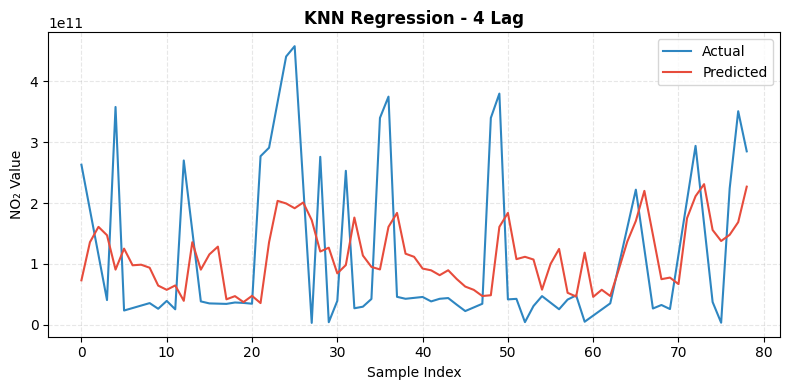


=== Plotting 5 Lag ===


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

for name, file_path in files:
    print(f"\n=== Plotting {name} ===")

    # 1️⃣ Load dataset
    df = pd.read_csv(file_path)
    X = df.drop(columns=['NO2'])
    y = df['NO2']

    # 2️⃣ Split (tanpa shuffle agar urutannya tetap)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 3️⃣ Normalisasi berdasarkan data training
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4️⃣ Model KNN
    knn = KNeighborsRegressor(n_neighbors=13)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # 5️⃣ Plot Actual vs Predicted
    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual", color="#2E86C1")
    plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted", color="#E74C3C")
    plt.title(f"KNN Regression - {name}", fontsize=12, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=10)
    plt.ylabel("NO₂ Value", fontsize=10)
    plt.legend()
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# =====================================================
# 1️⃣ Deteksi delimiter secara otomatis dan baca data
# =====================================================
with open("supervised_exp3.csv", "r") as f:
    first_line = f.readline()

if "\t" in first_line:
    sep = "\t"
elif ";" in first_line:
    sep = ";"
else:
    sep = ","

data = pd.read_csv("supervised_exp3.csv", sep=sep)
print(f"📄 Delimiter terdeteksi: '{sep}'")
print("Kolom data:", data.columns.tolist())

# Pastikan kolom sudah benar
if 'NO2' not in data.columns:
    # Kadang kolom bisa punya spasi
    data.columns = data.columns.str.strip()
    if 'NO2' not in data.columns:
        raise KeyError("Kolom 'NO2' tidak ditemukan. Periksa header CSV kamu!")

# =====================================================
# 2️⃣ Pisahkan fitur dan target
# =====================================================
X = data.drop(columns=['NO2'])
y = data['NO2']

# =====================================================
# 3️⃣ Normalisasi (fit di train, transform di train & test)
# =====================================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

train_size = int(0.8 * len(X))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# =====================================================
# 4️⃣ Daftar model yang akan diuji
# =====================================================
models = {
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, random_state=42),
    "SVR": SVR(kernel='rbf', C=100, gamma=0.05),
    "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42)
}

# =====================================================
# 5️⃣ Evaluasi model
# =====================================================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Kembalikan ke skala asli
    y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
    y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

    # Hindari pembagian nol saat MAPE
    nonzero_mask = y_test_real != 0
    mape = np.mean(np.abs((y_test_real[nonzero_mask] - y_pred_real[nonzero_mask]) / y_test_real[nonzero_mask])) * 100

    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae = mean_absolute_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)

    print(f"\n==================== {name} ====================")
    print(f"RMSE : {rmse:,.2f}")
    print(f"MAE  : {mae:,.2f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")

print("\n✅ Evaluasi selesai.")


📄 Delimiter terdeteksi: ','
Kolom data: ['NO2_t-5', 'NO2_t-4', 'NO2_t-3', 'NO2_t-2', 'NO2_t-1', 'NO2']

==================== GradientBoosting ====================
RMSE : 120,183,498,151.15
MAE  : 91,671,935,251.13
MAPE : 265.21%
R²   : 0.0907

==================== SVR ====================
RMSE : 113,898,937,214.94
MAE  : 85,688,832,573.35
MAPE : 272.98%
R²   : 0.1833

==================== MLP ====================
RMSE : 114,871,222,322.04
MAE  : 92,760,159,093.15
MAPE : 352.07%
R²   : 0.1693

✅ Evaluasi selesai.
